In [3]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
!pip install keras-metrics
!pip install scikit-plot
!pip install scipy
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import json

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
total_data = pd.read_csv("/content/drive/My Drive/cs230 project self/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [6]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)):
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i)
      wout_el = re.sub(pattern2,'\n',wout_sc)
      wout_mspaces = re.sub(pattern3,' ',wout_el)
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [7]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 94379/94379 [05:18<00:00, 296.03it/s]


In [8]:
pickle_file_path = "/content/drive/My Drive/cs230 project self/facts_opinions.pkl"
total_data.to_pickle(pickle_file_path)

In [9]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode ll hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


In [10]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [11]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.9,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.9,random_state=42)

In [12]:
x_test.to_csv("/content/drive/My Drive/cs230 project self/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/cs230 project self/y_test.csv",index=False)

In [13]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1393


In [14]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 76446/76446 [00:02<00:00, 26839.37it/s]


In [15]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data

In [16]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 76446/76446 [24:53<00:00, 51.17it/s]



Generating Vectors......


100%|██████████| 8495/8495 [03:15<00:00, 43.44it/s]



Generating Vectors......


100%|██████████| 9438/9438 [03:27<00:00, 45.51it/s]


In [15]:
import json
# Basic LSTM model with 0.01 learn rate and 1000 batch size
lstm_model1 = Sequential()
lstm_model1.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model1.add(LSTM(20))
lstm_model1.add(Dense(2, activation='softmax'))
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model1-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values1=lstm_model1.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model1_history.json', 'w') as f:
    json.dump(values1.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.8910 - loss: 0.2706
Epoch 1: val_loss improved from inf to 0.04151, saving model to /content/drive/My Drive/cs230 project self/saved models/model1-001-0.954543-0.986580.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - acc: 0.8918 - loss: 0.2689 - val_acc: 0.9866 - val_loss: 0.0415
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9925 - loss: 0.0286
Epoch 2: val_loss improved from 0.04151 to 0.04085, saving model to /content/drive/My Drive/cs230 project self/saved models/model1-002-0.992321-0.986463.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - acc: 0.9925 - loss: 0.0286 - val_acc: 0.9865 - val_loss: 0.0409
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9973 - loss: 0.0110
Epoch 3: val_loss did not improve from 0.04085
77/77 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - acc: 0.9973 - loss: 0.0110 - val_acc: 0.9860 - val_loss: 0.0483


In [16]:
# Basic LSTM model with 0.1 learn rate and 1000 batch size
lstm_model2 = Sequential()
lstm_model2.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model2.add(LSTM(20))
lstm_model2.add(Dense(2, activation='softmax'))
checkpoint2 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model2-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.1), metrics=['acc'])
values2=lstm_model2.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint2])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model2_history.json', 'w') as f:
    json.dump(values2.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9102 - loss: 0.1874
Epoch 1: val_loss improved from inf to 0.07209, saving model to /content/drive/My Drive/cs230 project self/saved models/model2-001-0.959919-0.973749.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - acc: 0.9108 - loss: 0.1864 - val_acc: 0.9737 - val_loss: 0.0721
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9865 - loss: 0.0429
Epoch 2: val_loss did not improve from 0.07209
77/77 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - acc: 0.9865 - loss: 0.0429 - val_acc: 0.9752 - val_loss: 0.0768
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9816 - loss: 0.0600
Epoch 3: val_loss did not improve from 0.07209
77/77 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - acc: 0.9815 - loss: 0.0602 - val_acc: 0.9540 - val_loss: 0.1423


In [17]:
# Basic LSTM model with 1 learn rate and 1000 batch size
lstm_model3 = Sequential()
lstm_model3.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model3.add(LSTM(20))
lstm_model3.add(Dense(2, activation='softmax'))
checkpoint3 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model3-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1.0), metrics=['acc'])
values3=lstm_model3.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint3])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model3_history.json', 'w') as f:
    json.dump(values3.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6350 - loss: 0.8725
Epoch 1: val_loss improved from inf to 0.61424, saving model to /content/drive/My Drive/cs230 project self/saved models/model3-001-0.661277-0.685815.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - acc: 0.6353 - loss: 0.8704 - val_acc: 0.6858 - val_loss: 0.6142
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6761 - loss: 0.6155
Epoch 2: val_loss improved from 0.61424 to 0.59456, saving model to /content/drive/My Drive/cs230 project self/saved models/model3-002-0.676857-0.686875.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - acc: 0.6761 - loss: 0.6154 - val_acc: 0.6869 - val_loss: 0.5946
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6863 - loss: 0.5946
Epoch 3: val_loss did not improve from 0.59456
77/77 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - acc: 0.6863 - loss: 0.5946 - val_acc: 0.6895 - val_loss: 0.6066


NameError: name 'json' is not defined

In [18]:
import json
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model3_history.json', 'w') as f:
    json.dump(values3.history, f)

In [19]:
# Basic LSTM model with 0.01 learn rate and 100 batch size
lstm_model4 = Sequential()
lstm_model4.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model4.add(LSTM(20))
lstm_model4.add(Dense(2, activation='softmax'))
checkpoint4 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model4-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model4.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values4=lstm_model4.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=100,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint4])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model4_history.json', 'w') as f:
    json.dump(values4.history, f)

Epoch 1/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - acc: 0.9512 - loss: 0.1326
Epoch 1: val_loss improved from inf to 0.03790, saving model to /content/drive/My Drive/cs230 project self/saved models/model4-001-0.974950-0.986933.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 678s 881ms/step - acc: 0.9512 - loss: 0.1325 - val_acc: 0.9869 - val_loss: 0.0379
Epoch 2/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - acc: 0.9947 - loss: 0.0174
Epoch 2: val_loss did not improve from 0.03790
765/765 ━━━━━━━━━━━━━━━━━━━━ 684s 884ms/step - acc: 0.9947 - loss: 0.0174 - val_acc: 0.9869 - val_loss: 0.0415
Epoch 3/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - acc: 0.9985 - loss: 0.0057
Epoch 3: val_loss did not improve from 0.03790
765/765 ━━━━━━━━━━━━━━━━━━━━ 667s 871ms/step - acc: 0.9985 - loss: 0.0057 - val_acc: 0.9843 - val_loss: 0.0620


In [20]:
# Basic LSTM model with 0.01 learn rate and 10 batch size
lstm_model5 = Sequential()
lstm_model5.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model5.add(LSTM(20))
lstm_model5.add(Dense(2, activation='softmax'))
checkpoint5 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model5-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model5.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values5=lstm_model5.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=10,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint5])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model5_history.json', 'w') as f:
    json.dump(values5.history, f)

Epoch 1/3
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - acc: 0.9659 - loss: 0.0954
Epoch 1: val_loss improved from inf to 0.05150, saving model to /content/drive/My Drive/cs230 project self/saved models/model5-001-0.975028-0.981165.keras
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 5048s 660ms/step - acc: 0.9659 - loss: 0.0954 - val_acc: 0.9812 - val_loss: 0.0515
Epoch 2/3
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - acc: 0.9869 - loss: 0.0405
Epoch 2: val_loss did not improve from 0.05150
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 5051s 659ms/step - acc: 0.9869 - loss: 0.0405 - val_acc: 0.9830 - val_loss: 0.0542
Epoch 3/3
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - acc: 0.9896 - loss: 0.0330
Epoch 3: val_loss did not improve from 0.05150
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 5052s 657ms/step - acc: 0.9896 - loss: 0.0330 - val_acc: 0.9798 - val_loss: 0.0595


In [52]:
model_paths = ['/content/drive/My Drive/cs230 project self/saved models/model1-002-0.993766-0.987508.keras',
               '/content/drive/My Drive/cs230 project self/saved models/model2-001-0.961586-0.961187.keras',
               '/content/drive/My Drive/cs230 project self/saved models/model3-003-0.703124-0.684140.keras',
               '/content/drive/My Drive/cs230 project self/saved models/model4-002-0.988318-0.983939.keras',
               '/content/drive/My Drive/cs230 project self/saved models/model5-002-0.986675-0.980593.keras'
]

In [57]:
from tensorflow.keras.utils import to_categorical
# Placeholder for evaluation results
results = {}

# Loop through each model, load it, and evaluate on x_test_vec
for model_path in model_paths:
    # Load the model
    model = load_model(model_path)

    # Evaluate the model on the test data
    y_test_one_hot = to_categorical(y_test, num_classes=2)

# Now you can evaluate the model
    loss, accuracy = model.evaluate(x_test_vec, y_test_one_hot, verbose=0)
    #loss, accuracy = model.evaluate(x_test_vec, y_test, verbose=0)

    # Store the results
    results[model_path] = {"loss": loss, "accuracy": accuracy}

# Print evaluation results for each model
for model_path, result in results.items():
    print(f"Model: {model_path}")
    print(f"  Loss: {result['loss']:.4f}")
    print(f"  Accuracy: {result['accuracy']:.4f}")


Model: /content/drive/My Drive/cs230 project self/saved models/model1-002-0.993766-0.987508.keras
  Loss: 0.0451
  Accuracy: 0.9841
Model: /content/drive/My Drive/cs230 project self/saved models/model2-001-0.961586-0.961187.keras
  Loss: 0.1431
  Accuracy: 0.9574
Model: /content/drive/My Drive/cs230 project self/saved models/model3-003-0.703124-0.684140.keras
  Loss: 0.5903
  Accuracy: 0.6860
Model: /content/drive/My Drive/cs230 project self/saved models/model4-002-0.988318-0.983939.keras
  Loss: 0.0584
  Accuracy: 0.9850
Model: /content/drive/My Drive/cs230 project self/saved models/model5-002-0.986675-0.980593.keras
  Loss: 0.0551
  Accuracy: 0.9822


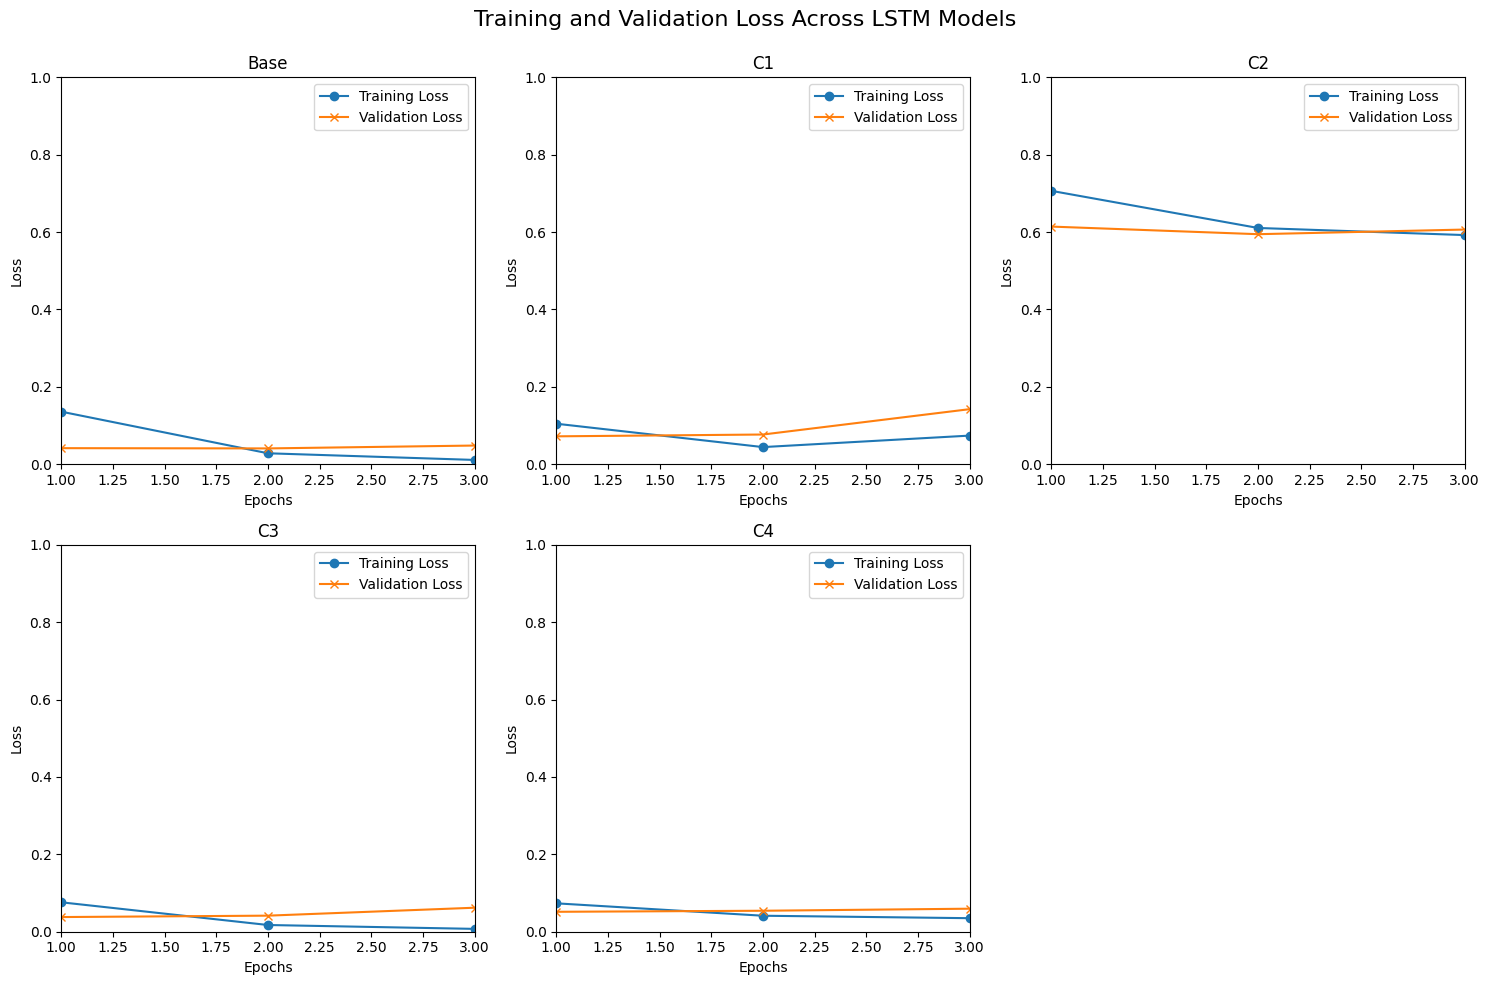

In [24]:
# File paths for the saved JSON histories
history_files = [
    '/content/drive/My Drive/cs230 project self/saved models/lstm_model1_history.json',
    '/content/drive/My Drive/cs230 project self/saved models/lstm_model2_history.json',
    '/content/drive/My Drive/cs230 project self/saved models/lstm_model3_history.json',
    '/content/drive/My Drive/cs230 project self/saved models/lstm_model4_history.json',
    '/content/drive/My Drive/cs230 project self/saved models/lstm_model5_history.json'
]

# Set up the figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes array for easy indexing (ignoring extra subplot space)
axes = axes.flatten()

# Loop through each model and plot the loss
for i, history_file in enumerate(history_files):
    # Load the history
    with open(history_file, 'r') as f:
        history = json.load(f)

    # Extract loss and validation loss
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plot in the respective subplot
    ax = axes[i]
    ax.plot(epochs, loss, label='Training Loss', marker='o')
    ax.plot(epochs, val_loss, label='Validation Loss', marker='x')
    if i == 0:
      ax.set_title('Base')
    else:
      ax.set_title(f'C{i}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, 3)
    ax.set_ylim(0, 1)
    ax.legend()

# Remove unused subplot (if any)
for j in range(len(history_files), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Training and Validation Loss Across LSTM Models', fontsize=16)
plt.show()


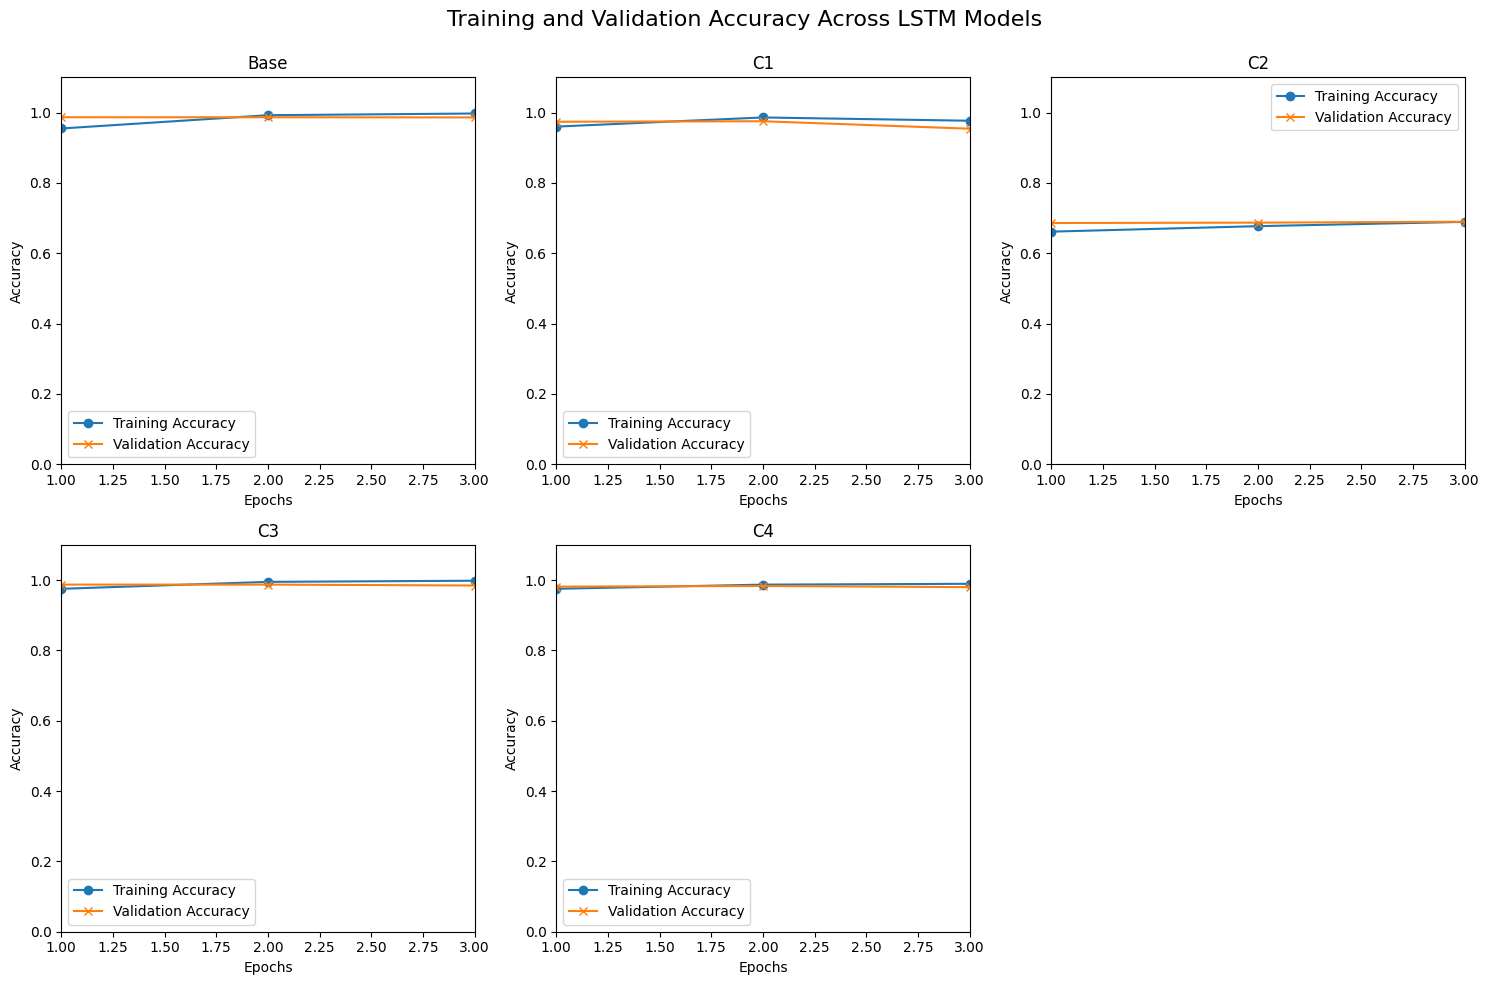

In [23]:
# Set up the figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes array for easy indexing (ignoring extra subplot space)
axes = axes.flatten()

# Loop through each model and plot the accuracy
for i, history_file in enumerate(history_files):
    # Load the history
    with open(history_file, 'r') as f:
        history = json.load(f)

    # Extract accuracy and validation accuracy
    acc = history['acc']
    val_acc = history['val_acc']
    epochs = range(1, len(acc) + 1)

    # Plot in the respective subplot
    ax = axes[i]
    ax.plot(epochs, acc, label='Training Accuracy', marker='o')
    ax.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
    if i == 0:
      ax.set_title('Base')
    else:
      ax.set_title(f'C{i}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, 3)
    ax.set_ylim(0, 1.1)
    ax.legend()

# Remove unused subplot (if any)
for j in range(len(history_files), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Training and Validation Accuracy Across LSTM Models', fontsize=16)
plt.show()
